In [8]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col,md5
import matplotlib.pyplot as plt


# Crear SparkSession
spark = SparkSession.builder.appName("Grandata_Test").getOrCreate()


# Creo las variables con la ruta de los archivos de datos 
ruta_eventos_csv="/home/jovyan/data/events.csv.gz"
ruta_destinso_csv="/home/jovyan/data/free_sms_destinations.csv.gz"


# Leer el archivo CSV como DataFrame
df_eventos = spark.read.csv(ruta_eventos_csv, header=True, inferSchema=True)
df_destinos = spark.read.csv(ruta_destinso_csv, header=True, inferSchema=True)

# Mostrar las primeras filas del DataFrame para verificar
df_eventos.show()
df_destinos.show()

# Creo temporales     
df_eventos.createOrReplaceTempView("eventos")
df_destinos.createOrReplaceTempView("destinos_gratuitos")




ConnectionRefusedError: [Errno 61] Connection refused

In [7]:

# Con la query calculamos la el costo total a facturar de la empresa.
df_costo_total = spark.sql(f""" SELECT 
                            SUM( CASE 
                                    WHEN CAST(region AS INT) BETWEEN 1 AND 5 THEN 1.5
                                    WHEN CAST(region AS INT) BETWEEN 6 AND 9 THEN 2
                                    ELSE 0 
                                END ) AS costo_total
                            FROM eventos
                            LEFT JOIN destinos_gratuitos ON eventos.id_destination = destinos_gratuitos.id
                            WHERE destinos_gratuitos.id IS NULL 
                            AND id_destination IS NOT NULL 
                            AND id_source IS NOT NULL
                                        """)


df_costo_total.createOrReplaceTempView("costo_total")

df_costo_total.show()




ConnectionRefusedError: [Errno 61] Connection refused

In [36]:
# Asumiendo que tienes una columna 'destino' y una 'costo_sms'
# Primero eliminamos aqueelos con id null y tambien aquellos que no tienen costo el envio de msj 
df_costo_usuario = spark.sql(f""" SELECT md5(id_source) AS ID_SOURCE,
                            SUM( CASE 
                                    WHEN CAST(region AS INT) BETWEEN 1 AND 5 THEN 1.5
                                    WHEN CAST(region AS INT) BETWEEN 6 AND 9 THEN 2
                                    ELSE 0 
                                END ) AS costo
                            FROM eventos
                            LEFT JOIN destinos_gratuitos ON eventos.id_destination = destinos_gratuitos.id
                            WHERE destinos_gratuitos.id IS NULL 
                            AND id_destination IS NOT NULL 
                            AND id_source IS NOT NULL
                     GROUP BY id_source
                     ORDER BY costo desc 
                     LIMIT 100
                                        """)



df_costo_usuario.createOrReplaceTempView("costo_por_usuario")

df_costo_usuario.show()                  

df_costo_usuario.write.mode("overwrite").parquet("/Users/a309594/Documents/Celes/grandata-test/data/parquet", compression="gzip")


+--------------------+-------+
|           ID_SOURCE|  costo|
+--------------------+-------+
|911914c7729eedbdf...|18573.0|
|bd180b7811395cbce...|13508.0|
|14a0660ae2f5d1868...| 4070.0|
|16c222aa19898e505...| 1707.0|
|bc97b32ee2abb9c18...| 1292.5|
|6a57072949dbc409c...| 1026.0|
|f5a45e33602ea62f9...| 1023.5|
|e9d076deb3451cc49...| 1015.5|
|1b2e80021b5fc82bf...|  892.0|
|159e1f3d6ff0e7c3c...|  714.5|
|4e321438558549248...|  702.0|
|aeb3135b436aa5537...|  680.0|
|496ce5f942d15eefb...|  652.0|
|beed13602b9b0e6ec...|  626.5|
|aa35b36e4d1395542...|  616.0|
|e87c495061191f4df...|  611.5|
|2823f4797102ce1a1...|  610.5|
|11b921ef080f77360...|  605.5|
|13d8d90116cbacd3a...|  603.5|
|49159f42b0f043d6d...|  592.5|
+--------------------+-------+
only showing top 20 rows



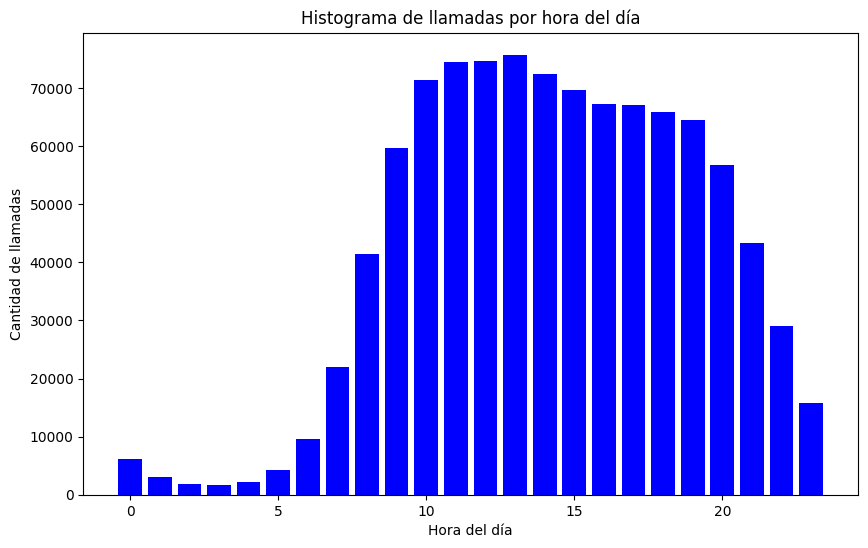

24/02/12 18:23:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 902539 ms exceeds timeout 120000 ms
24/02/12 18:23:20 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/12 18:23:27 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [ ]:
llamadas_por_hora_df = df_eventos.groupBy("hour").count()

# Convertir a Pandas DataFrame para graficar
pd_df = llamadas_por_hora_df.toPandas()

# Ordenar por hora
pd_df.sort_values("hour", inplace=True)

# Graficar
plt.figure(figsize=(10,6))
plt.bar(pd_df["hour"], pd_df["count"], color='blue')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de llamadas')
plt.title('Histograma de llamadas por hora del día')
plt.savefig('/Users/a309594/Documents/Celes/grandata-test/histograma_llamadas_por_hora.png')